# Simple Strategy Notebook

Welcome to the Simple Strategy Notebook.<br>
In this notebook we are going to explore a simple strategy to trade an asset using sentiment data from `reddit` comments.<br>

**Quick overview of the data**:
The data consists of a `.csv` file with the following columns:
date;avg_sentiment;submission_count;Open;High;Low;Close;Adj Close;Volume
- **date**: the date with format `YYYY-MM-DD`
- **avg_sentiment**: the average sentiment of the comments in the subreddit on that specific day
- **submission_count**: the number of submissions in the subreddit on that specific day related to the asset
- **Open**: the opening price of the asset on that specific day
- **High**: the highest price of the asset on that specific day
- **Low**: the lowest price of the asset on that specific day
- **Close**: the closing price of the asset on that specific day
- **Adj Close**: the adjusted closing price of the asset on that specific day
- **Volume**: the volume of the asset on that specific day

**Objective**:
The objective of this notebook is to create a simple strategy to trade an asset using the sentiment data from `reddit` comments. The strategy should be simple and easy to understand.

**Strategy**:
The strategy is simple and consists of the following steps:
Our study is always done on a window of 3 days.
1. If the average sentiment variance is higher than a certain threshold, we buy the asset.
2. If the average sentiment variance is lower than a certain threshold, we sell the asset.
3. If the average sentiment variance is between the buy and sell thresholds, we hold the asset.

## Table of Contents
1. [Importing the Libraries](#1.-Importing-the-Libraries)
2. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
3. [Creating the Strategy](#4.-Creating-the-Strategy)
4. [Backtesting the Strategy](#5.-Backtesting-the-Strategy)
5. [Conclusion](#6.-Conclusion)

## 1. Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Exploratory Data Analysis

### 2.1 Load the Data

In [2]:
asset_data = pd.read_csv('Data/final/tsla_data_bis.csv', sep=';')

# sorting the data by date
asset_data = asset_data.sort_values(by='date')
# reset the index
asset_data = asset_data.reset_index(drop=True)
# presenting the data
asset_data.head()

,date,avg_sentiment,submission_count,Open,High,Low,Close,Adj Close,Volume
0,2013-06-27,0.0,3,7.116667,7.350000,7.075333,7.283333,7.283333,131173500
1,2013-06-28,0.0,1,7.238000,7.296000,7.114000,7.157333,7.157333,86229000
2,2013-07-01,0.0,2,7.290667,7.851333,7.276667,7.812000,7.812000,163554000
3,2013-07-02,0.0,1,7.883333,8.126000,7.700000,7.854667,7.854667,180961500
4,2013-07-03,1.0,1,7.866667,7.950000,7.618000,7.682667,7.682667,72100500


### 2.2 Data Processing/Feature Engineering

In [3]:
# 3-day rolling variance of the average sentiment
asset_data['sentiment_rolling_var'] = asset_data['avg_sentiment'].rolling(window=120).var()
asset_data['sentiment_change'] = asset_data['sentiment_rolling_var'].diff()
# drop the resulting NaN values
asset_data = asset_data.dropna()

In [4]:
# add 3 day rolling sentiment average
# asset_data['sentiment_rolling_avg'] = asset_data['avg_sentiment'].rolling(window=30).mean()

### 2.3 Sentiment Visualization

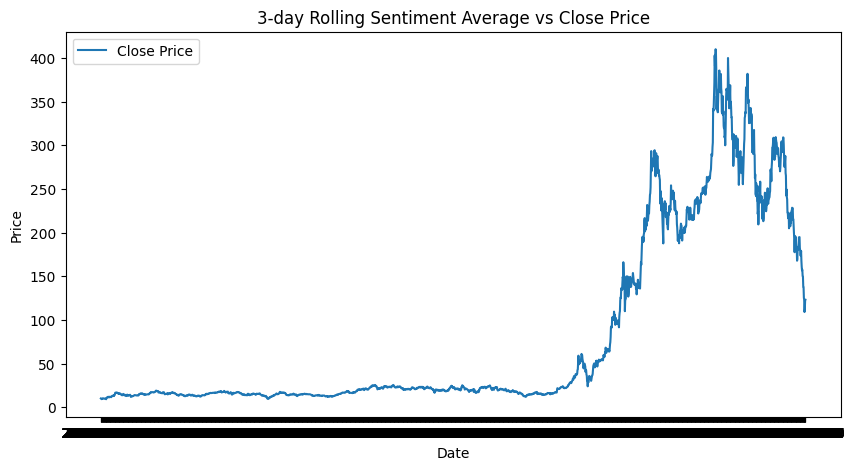

In [5]:
# plot a 3 day rolling window of the average sentiment and the close price on the same graph for comparison keep in mind the difference in scale
# we want them to be on the same scale
plt.figure(figsize=(10, 5))
plt.plot(asset_data['date'], asset_data['Close'], label='Close Price')
# plt.plot(asset_data['date'], asset_data['sentiment_rolling_avg'], label='Sentiment')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('3-day Rolling Sentiment Average vs Close Price')
plt.legend()
plt.show()



In [6]:
df = asset_data[['sentiment_rolling_var', 'Close', 'date']].copy()
df['avg_sentiment'] = asset_data['avg_sentiment'].rolling(window=120).mean()
df.dropna(inplace=True)

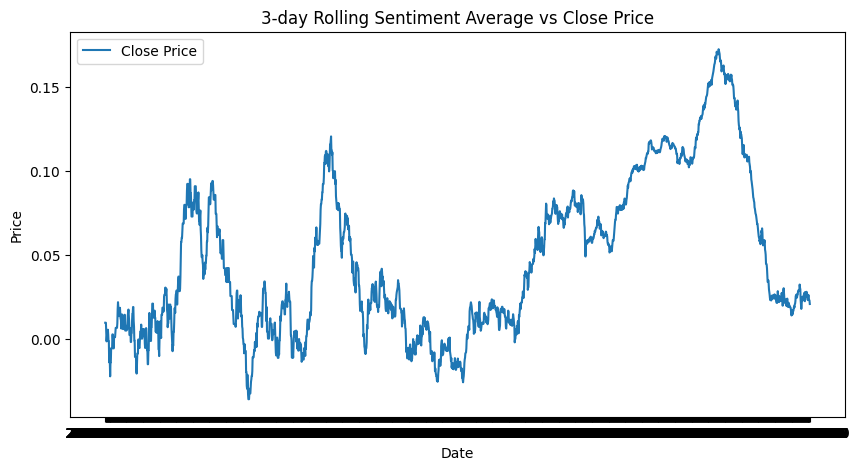

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['avg_sentiment'], label='Close Price')
# plt.plot(asset_data['date'], asset_data['sentiment_rolling_avg'], label='Sentiment')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('3-day Rolling Sentiment Average vs Close Price')
plt.legend()
plt.show()

### 2.3 Data Splitting (Train and Test)

In [8]:
# Splitting the dataset into training and testing sets (first 80% of data for training, last 20% for testing)
train_size = int(0.8 * asset_data.shape[0])
train_df = asset_data.iloc[:train_size]
test_df = asset_data.iloc[train_size:]

## 3. Creating the Strategy

### 3.1 Finding Optimal Thresholds

All the above sections are relatively straightforward<br>
Now we move on to the strategy creation section.<br>
Our trading strategy is based on finding the **optimal thresholds** for buying and selling the asset.<br>

We will use the `train` data to find the optimal thresholds.<br>
Using a **Bayesian Optimization** technique, we will find the optimal thresholds for buying and selling the asset.<br>

In [9]:
from bayes_opt import BayesianOptimization

In [10]:
# Function to evaluate the strategy with given thresholds
def evaluate_strategy_with_thresholds(df, buy_threshold, sell_threshold):
    df = apply_strategy_with_thresholds(df, buy_threshold, sell_threshold)
    df = backtest_with_thresholds(df)
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * (252**0.5)
    return sharpe_ratio

In [11]:
## Helper functions

def apply_strategy_with_thresholds(df, buy_threshold, sell_threshold):
    df['Signal'] = 0
    df.loc[(df['sentiment_change'] > buy_threshold), 'Signal'] = 1
    df.loc[(df['sentiment_change'] < sell_threshold), 'Signal'] = -1
    return df

def backtest_with_thresholds(df):
    df['return'] = df['Close'].pct_change()
    df['strategy_return'] = df['Signal'].shift(1) * df['return']
    df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()
    return df

def evaluate_strategy_with_thresholds(buy_threshold, sell_threshold):
    df = train_df.copy()
    
    df = apply_strategy_with_thresholds(df, buy_threshold, sell_threshold)
    df = backtest_with_thresholds(df)
    
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * (252**0.5)
    return sharpe_ratio

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

# Load the dataset
df = pd.read_csv('data/final/goog_data_bis.csv', parse_dates=['date'], sep=';')

# Preprocess the data
df.sort_values(by='date', inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Ensure the 'date' column is set as the index and is of datetime type
df.set_index('date', inplace=True)

# Calculate the 3-day rolling variance and rate of change of the average sentiment
df['Sentiment_Variance'] = df['avg_sentiment'].rolling(window=3).var()
df['Sentiment_Change'] = df['avg_sentiment'].diff()

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)

# Function to apply strategy based on thresholds
def apply_strategy_with_thresholds(df, buy_threshold, sell_threshold):
    df['Signal'] = 0
    df.loc[(df['Sentiment_Change'] > buy_threshold) & (df['Sentiment_Variance'] > buy_threshold), 'Signal'] = 1
    df.loc[(df['Sentiment_Change'] < sell_threshold) & (df['Sentiment_Variance'] > sell_threshold), 'Signal'] = -1
    return df

# Function to backtest the strategy
def backtest_with_thresholds(df):
    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df['Signal'].shift(1) * df['Return']
    df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod()
    return df

# Function to evaluate the strategy with given thresholds
def evaluate_strategy_with_thresholds(df, buy_threshold, sell_threshold):
    df = apply_strategy_with_thresholds(df, buy_threshold, sell_threshold)
    df = backtest_with_thresholds(df)

    # handle division by zero
    if df['Strategy_Return'].std() == 0:
        return 0
    

    sharpe_ratio = df['Strategy_Return'].mean() / df['Strategy_Return'].std() * (252**0.5)
    return sharpe_ratio

# Initialize lists to store results
dates = []
cumulative_strategy_returns = []

# Split the data into weekly periods
weekly_groups = list(df.groupby(pd.Grouper(freq='M')))

# Iterate over each week except the last one, because there's no next week to apply the strategy to
for i in range(len(weekly_groups) - 1):
    current_week, current_week_data = weekly_groups[i]
    next_week, next_week_data = weekly_groups[i + 1]

    current_week_data.dropna(inplace=True)
    next_week_data.dropna(inplace=True)

    
    if len(current_week_data) < 18 or len(next_week_data) < 18:  # Ensure there is enough data for the weeks
        continue
    
    # Define the bounds for Bayesian Optimization
    pbounds = {
        'buy_threshold': (current_week_data['Sentiment_Change'].quantile(0.5), current_week_data['Sentiment_Change'].quantile(0.95)),
        'sell_threshold': (current_week_data['Sentiment_Change'].quantile(0.05), current_week_data['Sentiment_Change'].quantile(0.5))
    }
    
    # Optimize the buy and sell thresholds using Bayesian Optimization
    optimizer = BayesianOptimization(
        f=lambda buy_threshold, sell_threshold: evaluate_strategy_with_thresholds(current_week_data, buy_threshold, sell_threshold),
        pbounds=pbounds,
        random_state=42,
        allow_duplicate_points=True  # Allow duplicate points
    )
    
    optimizer.maximize(init_points=10, n_iter=30)
    
    best_params = optimizer.max['params']
    best_buy_threshold = best_params['buy_threshold']
    best_sell_threshold = best_params['sell_threshold']
    
    # Apply the strategy with the optimal thresholds for the next week
    next_week_data = apply_strategy_with_thresholds(next_week_data, best_buy_threshold, best_sell_threshold)
    next_week_data = backtest_with_thresholds(next_week_data)
    
    # Store the results
    dates.extend(next_week_data.index)
    cumulative_strategy_returns.extend(next_week_data['Cumulative_Strategy_Return'])

# Create a DataFrame for the cumulative strategy returns
results_df = pd.DataFrame({'date': dates, 'Cumulative_Strategy_Return': cumulative_strategy_returns})
results_df.set_index('date', inplace=True)




/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_6496/2770729517.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_groups = list(df.groupby(pd.Grouper(freq='M')))


|   iter    |  target   | buy_th... | sell_t... |
-------------------------------------------------
| 1         | 1.753     | 0.2076    | -0.03475  |
| 2         | 2.301     | 0.4058    | -0.2829   |
| 3         | 0.6912    | 0.08649   | -0.595    |
| 4         | 3.396     | 0.0322    | -0.09435  |
| 5         | 2.803     | 0.3332    | -0.2058   |
| 6         | 5.047     | 0.01141   | -0.02121  |
| 7         | -4.05     | 0.4615    | -0.5553   |
| 8         | 0.6912    | 0.1008    | -0.5757   |
| 9         | 3.954     | 0.1687    | -0.335    |
| 10        | -4.05     | 0.2395    | -0.4997   |
| 11        | 5.402     | 0.0       | -0.3421   |
| 12        | 1.753     | 0.5544    | -0.02649  |
| 13        | 2.845     | 0.0       | -0.4516   |
| 14        | 3.707     | 0.07562   | -0.2619   |
| 15        | 2.803     | 0.554     | -0.2033   |
| 16        | 4.451     | 0.07165   | -0.3629   |
| 17        | 0.7996    | 0.2449    | -0.1238   |
| 18        | 3.194     | 0.07921   | 0.0       |


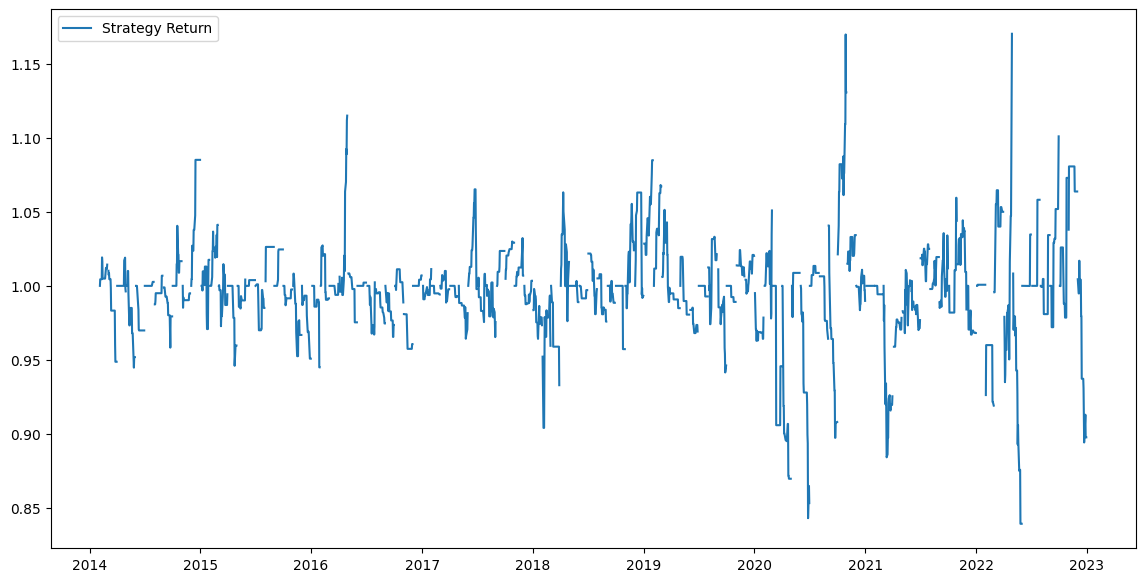

In [16]:
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Cumulative_Strategy_Return'], label='Strategy Return')
plt.legend()
plt.show()

In [17]:
# Evaluate the overall performance
def evaluate_performance(df):
    sharpe_ratio = df['Cumulative_Strategy_Return'].pct_change().mean() / df['Cumulative_Strategy_Return'].pct_change().std() * (252**0.5)
    max_drawdown = (df['Cumulative_Strategy_Return'].cummax() - df['Cumulative_Strategy_Return']).max()
    cumulative_return = df['Cumulative_Strategy_Return'].iloc[-1]
    print(f'Sharpe Ratio: {sharpe_ratio}')
    print(f'Max Drawdown: {max_drawdown}')
    print(f'Cumulative Return: {cumulative_return}')

evaluate_performance(results_df)

Sharpe Ratio: 0.06007450187400769
Max Drawdown: 0.3306053860197776
Cumulative Return: 0.8977806474291424


/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_6496/1122406982.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sharpe_ratio = df['Cumulative_Strategy_Return'].pct_change().mean() / df['Cumulative_Strategy_Return'].pct_change().std() * (252**0.5)


In [ ]:
# Create a DataFrame for the cumulative strategy returns
results_df = pd.DataFrame({'date': dates, 'Cumulative_Strategy_Return': cumulative_strategy_returns})

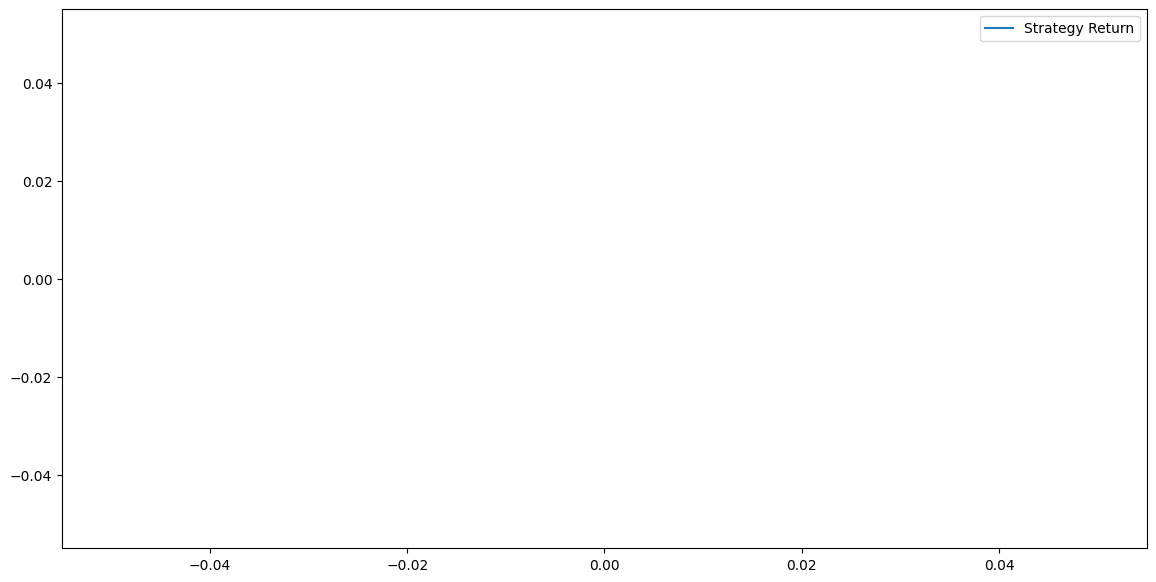

In [12]:
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(results_df['date'], results_df['Cumulative_Strategy_Return'], label='Strategy Return')
plt.legend()
plt.show()

In [13]:
# Evaluate the overall performance
def evaluate_performance(df):
    sharpe_ratio = df['Cumulative_Strategy_Return'].pct_change().mean() / df['Cumulative_Strategy_Return'].pct_change().std() * (252**0.5)
    max_drawdown = (df['Cumulative_Strategy_Return'].cummax() - df['Cumulative_Strategy_Return']).max()
    cumulative_return = df['Cumulative_Strategy_Return'].iloc[-1]
    print(f'Sharpe Ratio: {sharpe_ratio}')
    print(f'Max Drawdown: {max_drawdown}')
    print(f'Cumulative Return: {cumulative_return}')

evaluate_performance(results_df)

IndexError: single positional indexer is out-of-bounds

In [20]:
# Defining the bounds for the thresholds
pbounds = {
    'buy_threshold': (train_df['sentiment_change'].quantile(0.5), train_df['sentiment_change'].quantile(0.95)),
    'sell_threshold': (train_df['sentiment_change'].quantile(0.05), train_df['sentiment_change'].quantile(0.5))
}

# Initializing the Bayesian Optimizer
optimizer = BayesianOptimization(
    f=evaluate_strategy_with_thresholds,
    pbounds=pbounds,
    random_state=42
)

In [21]:
# Performing optimization
optimizer.maximize(
    init_points=10,  # Number of random points to evaluate before starting the optimization
    n_iter=30  # Number of iterations of the optimization
)

# Getting the best thresholds
best_params = optimizer.max['params']
best_buy_threshold = best_params['buy_threshold']
best_sell_threshold = best_params['sell_threshold']

print(f'Best Buy Threshold: {best_buy_threshold}')
print(f'Best Sell Threshold: {best_sell_threshold}')


|   iter    |  target   | buy_th... | sell_t... |
-------------------------------------------------
| 1         | -0.1677   | 0.002219  | -0.000345 |
| 2         | 0.1473    | 0.004336  | -0.002815 |
| 3         | 0.3209    | 0.0009241 | -0.00592  |
| 4         | -0.3055   | 0.000344  | -0.000938 |
| 5         | 0.07824   | 0.003561  | -0.002048 |
| 6         | -0.3297   | 0.0001219 | -0.000211 |
| 7         | 0.2851    | 0.004931  | -0.005525 |
| 8         | 0.261     | 0.001077  | -0.005728 |
| 9         | 0.463     | 0.001802  | -0.003334 |
| 10        | 0.3932    | 0.002559  | -0.004972 |
| 11        | 0.5617    | 0.0       | -0.007014 |
| 12        | 0.4949    | 0.002925  | -0.007014 |
| 13        | 0.3681    | 0.005923  | -0.007014 |
| 14        | 0.5238    | 0.001354  | -0.007014 |
| 15        | -0.5583   | 0.005923  | 0.0       |
| 16        | 0.3425    | 0.004326  | -0.007014 |
| 17        | 0.3553    | 0.002997  | -0.003723 |
| 18        | 0.5294    | 0.0       | -0.003864 |


## 4. Backtesting the Strategy

### 4.1 Applying the Strategy on the Test Data

In [22]:
# Apply the strategy with the optimal thresholds
train_df = apply_strategy_with_thresholds(train_df, best_buy_threshold, best_sell_threshold)
test_df = apply_strategy_with_thresholds(test_df, best_buy_threshold, best_sell_threshold)

# Backtest the strategy
train_df = backtest_with_thresholds(train_df)
test_df = backtest_with_thresholds(test_df)

/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_6215/4105661020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = 0
/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_6215/4105661020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = 0
/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_6215/4105661020.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

### 4.2 Evaluating the Strategy

In [23]:
## Helper function
def evaluate_performance(df):
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * (252**0.5)
    max_drawdown = (df['cumulative_strategy_return'].cummax() - df['cumulative_strategy_return']).max()
    cumulative_return = df['cumulative_strategy_return'].iloc[-1]
    print(f'Sharpe Ratio: {sharpe_ratio}')
    print(f'Max Drawdown: {max_drawdown}')
    print(f'Cumulative Return: {cumulative_return}')

In [24]:
# Evaluate performance on both training and test sets
print("Training Set Performance:")
evaluate_performance(train_df)

print("\nTest Set Performance:")
evaluate_performance(test_df)

Training Set Performance:
Sharpe Ratio: 0.5673095912304789
Max Drawdown: 0.7396812225222826
Cumulative Return: 1.897170701081597

Test Set Performance:
Sharpe Ratio: -0.7268700408798648
Max Drawdown: 0.09359746272529057
Cumulative Return: 0.9246629077599763


### 4.3 Visualizing the Strategy

In [25]:
import matplotlib.pyplot as plt

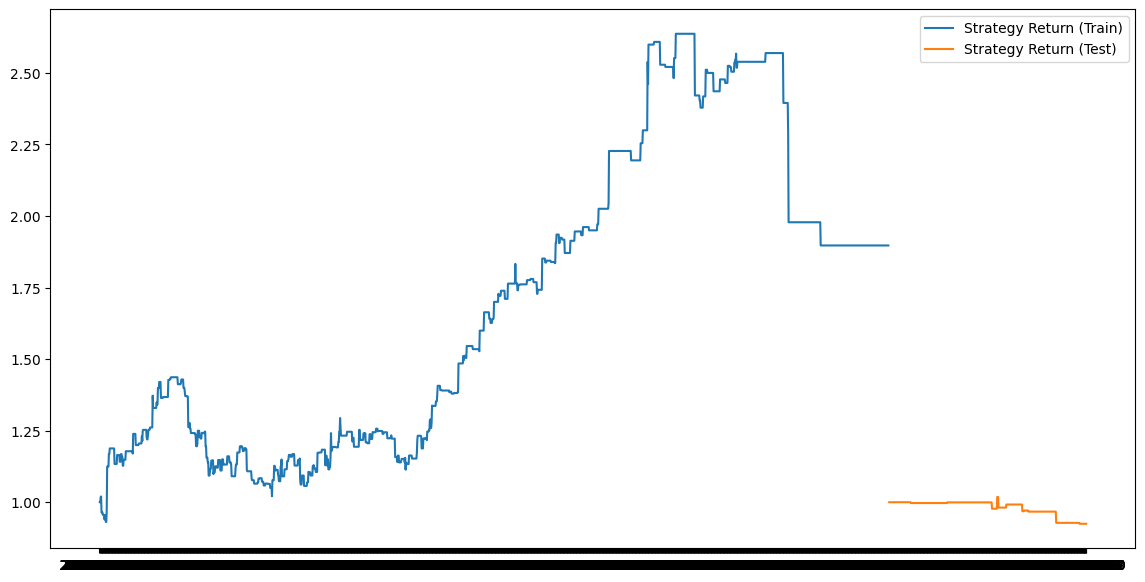

In [26]:
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(train_df['date'], train_df['cumulative_strategy_return'], label='Strategy Return (Train)')
plt.plot(test_df['date'], test_df['cumulative_strategy_return'], label='Strategy Return (Test)')
plt.legend()
plt.show()